In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ../..

/Users/purzelrakete/src/github.com/feldberlin/wavenet


In [2]:
import os

import numpy as np
import torch
import librosa
from torch.nn import functional as F
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd

from wavenet import model, train, sample, audio, datasets, utils, viz, debug

normalising input embeddings
normalising causal shifted conv1d
normalising resblock
normalising resblock
normalising conv1d
normalising conv1d
+------------------------------+------------+
|           Modules            | Parameters |
+------------------------------+------------+
|         embed.weight         |    8192    |
|        shifted.weight        |    4096    |
|     shifted.norm.weight      |     32     |
|      shifted.norm.bias       |     32     |
|     layers.0.conv.weight     |    4096    |
|  layers.0.conv.norm.weight   |     64     |
|   layers.0.conv.norm.bias    |     64     |
|    layers.0.res1x1.weight    |    1024    |
| layers.0.res1x1.norm.weight  |     32     |
|  layers.0.res1x1.norm.bias   |     32     |
|   layers.0.skip1x1.weight    |    1024    |
| layers.0.skip1x1.norm.weight |     32     |
|  layers.0.skip1x1.norm.bias  |     32     |
|     layers.1.conv.weight     |    4096    |
|  layers.1.conv.norm.weight   |     64     |
|   layers.1.conv.norm.bias  

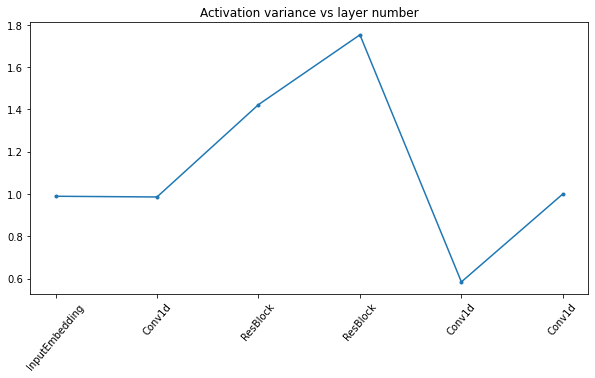

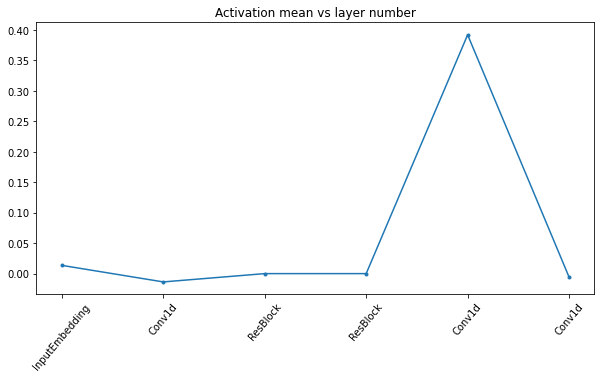

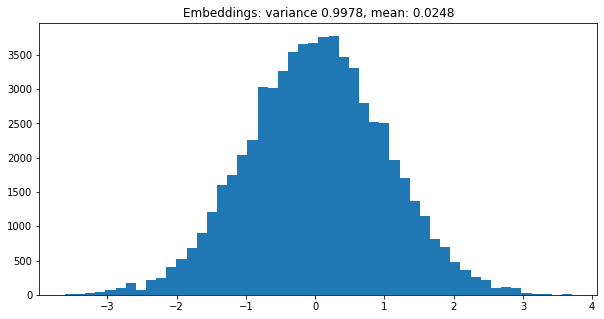

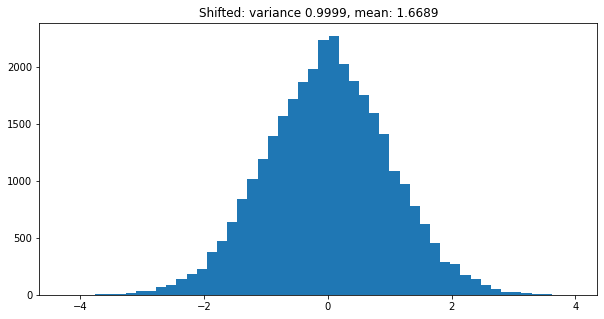

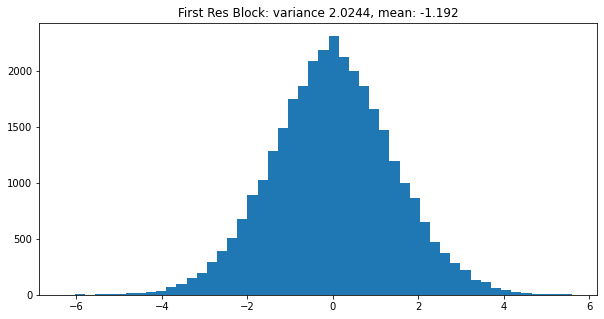

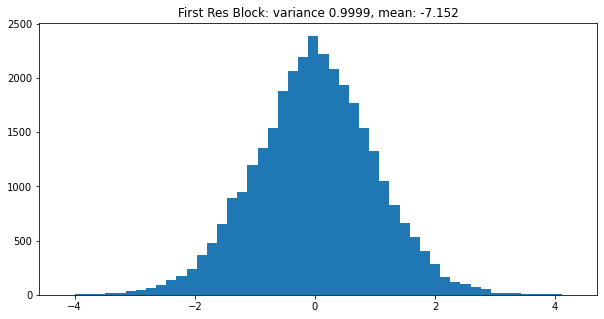

In [33]:
p = model.HParams(
    embed_inputs=True, 
    mixed_precision=False, 
    batch_norm=True, 
    dilation_stacks=2, 
    n_layers=1
).with_all_chans(32)

m = model.Wavenet(p)
debug.summarize(m)

# capture activations
memo = {}
debug.activations(m, memo)
x = torch.randint(p.n_classes, (10, p.n_audio_chans, 100), dtype=torch.long)
_ = m(x, x)
keys = [str(k).split('(')[0] for k in memo.keys()]
values = list(memo.values())

# plot variance vs each module output
plt.figure(figsize=(10, 5))
plt.title(f'Activation variance vs layer number')
plt.xticks(range(len(keys)), keys, rotation=50)
plt.plot(range(len(memo)), [x.std().item() for (x, *_) in values], marker='.')

# plot mean vs each module output
plt.figure(figsize=(10, 5))
plt.title(f'Activation mean vs layer number')
plt.xticks(range(len(keys)), keys, rotation=50)
plt.plot(range(len(memo)), [x.mean().item() for (x, *_) in values], marker='.')

def fn(title, layer_index, activation=lambda x: x):
    _, activations = list(memo.items())[layer_index]
    if type(activations) == torch.Tensor:
        activations = [activations]
    for x in list(activations):
        x = x.detach().numpy().flatten()
        x = activation(torch.from_numpy(x)).numpy()
        plt.figure(figsize=(10, 5))
        plt.title(f"{title}: variance {str(x.var())[:6]}, mean: {str(x.mean())[:6]}")
        plt.hist(x, 50)
        plt.show()
        plt.close()
        
fn('Embeddings', 0)
fn('Shifted', 1)
fn('First Res Block', 2)